In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
df = pd.read_csv("outputs_v3.csv")

In [3]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'name', 'main_category',
       'sub_category', 'image', 'link', 'ratings', 'no_of_ratings',
       'discount_price', 'actual_price', 'img_path', 'actual_price_yen',
       'embedding_path', 'embedding', 'price_ave', 'output', 'output_2v',
       'brightness', 'light_or_dark'],
      dtype='object')

## 傾向スコアの計算

In [7]:
df.price_ave

0       1
1       0
2       1
3       1
4       0
       ..
5106    0
5107    0
5108    0
5109    1
5110    0
Name: price_ave, Length: 5111, dtype: int64

In [4]:

# 'light_or_dark'が'dark'である行をフィルタリング
dark_data = df[df['light_or_dark'] == 'dark']
# 'prive_ave'が1である行の割合を計算
probability = (dark_data['price_ave'] == 1).mean()

print(f"light_or_darkがdarkであるもののうち、prive_aveが1である確率: {probability}")

light_or_darkがdarkであるもののうち、prive_aveが1である確率: 0.2912442396313364


In [5]:
# 'light_or_dark'が'dark'である行をフィルタリング
dark_data = df[df['light_or_dark'] == 'light']
# 'prive_ave'が1である行の割合を計算
probability = (dark_data['price_ave'] == 1).mean()

print(f"light_or_darkがlightであるもののうち、prive_aveが1である確率: {probability}")

light_or_darkがlightであるもののうち、prive_aveが1である確率: 0.33184302036761054


## 結果のシミュレーション

In [6]:
price_ave_given_dark_probs = np.array([0.29,0.33])

In [30]:
def outcome_sim(beta0, beta1, gamma, treatment, confounding, noise, setting = "simple"):
    if setting == "simple":
        y0 = beta1 * confounding
        y1 = beta0 * y0

        simulated_score = (1. - treatment) * y0 + treatment * y1 + gamma * noise
    return simulated_score, y0,y1
import numpy.random as random
from scipy.special import expit
def make_price_dark_probs(df,treat_strength,con_strength, noise_level, setting = "simple", seed = 0):
    price_ave_given_dark_probs = np.array([0.29,0.33])

    np.random.seed(seed)
    all_noise = np.array(random.normal(0,1,len(df)), dtype = np.float32)
    all_thresholds = np.array(random.uniform(0,1,len(df)), dtype = np.float32)
    
    outcomes = []
    y0s = []
    y1s = []

    for i, data in df.iterrows():
        light_or_dark = 1 if data["light_or_dark"] == "light" else 0
        treatment = data["price_ave"]

        confounding = 3.0 * (price_ave_given_dark_probs[light_or_dark] - 0.25)
        noise = all_noise[i]
        y,y0,y1 = outcome_sim(treat_strength, con_strength, noise_level,treatment, confounding, noise, setting = setting)
        print(y,y0,y1)
        simulated_prob = expit(y)
        y0 = expit(y0)
        y1 = expit(y1)
        threshold = all_thresholds[i]
        simulated_outcome = 1 if simulated_prob > threshold else 0
        outcomes.append(simulated_outcome)
        y0s.append(y0)
        y1s.append(y1)
        
    df['outcome'] = outcomes
    df['y0'] = y0s
    df['y1'] = y1s
    return df

In [31]:
df = make_price_dark_probs(df,0.5, 5.0,0.0,"simple", 0)

0.6000000000000001 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
0.6000000000000001 1.2000000000000002 0.6000000000000001
0.6000000000000001 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
0.5999999999999996 0.5999999999999996 0.2999999999999998
1.2000000000000002 1.2000000000000002 0.6000000000000001
0.5999999999999996 0.5999999999999996 0.2999999999999998
1.2000000000000002 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000000002 0.6000000000000001
0.6000000000000001 1.2000000000000002 0.6000000000000001
1.2000000000000002 1.2000000000

In [32]:
df.outcome.value_counts()

outcome
1    3647
0    1464
Name: count, dtype: int64

(array([1085.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 4026.]),
 array([0.48125878, 0.48499654, 0.48873429, 0.49247205, 0.49620981,
        0.49994756, 0.50368532, 0.50742307, 0.51116083, 0.51489858,
        0.51863634, 0.52237409, 0.52611185, 0.5298496 , 0.53358736,
        0.53732511, 0.54106287, 0.54480062, 0.54853838, 0.55227614,
        0.55601389]),
 <BarContainer object of 20 artists>)

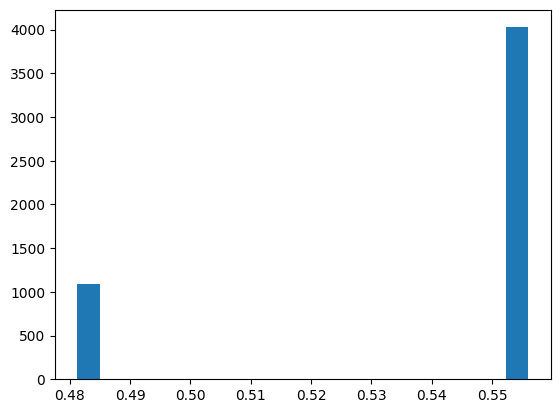

In [24]:
import matplotlib.pyplot as plt
plt.hist(df["y1"],bins=20)